In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from zo_optimizer import ZOOptimizer


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def compute_loss(net, x, target):
    output = net(x)
    loss = F.mse_loss(output, target)
    return loss


def compute_loss_2(output, target):
    loss = F.mse_loss(output, target)
    return loss

In [70]:
# generate synthetic data
x = torch.randn(10).to('cuda')
target = torch.randn(1).to('cuda')

# create model
net = Net().to('cuda')

# fo gradient
net.zero_grad()
loss = compute_loss(net, x, target)
loss.backward()

grad = []
for param in net.parameters():
    if param.grad is not None:
        grad.append(param.grad.clone().view(-1))

grad = torch.cat(grad)

q = 200

# zo gradient
net.zero_grad()
optimizer = ZOOptimizer(optim.SGD, net.parameters(), compute_loss, q=q, mu=1e-5, sides=1)
optimizer.step(net, x, target)

grad_zo = []
for param in net.parameters():
    if param.grad is not None:
        grad_zo.append(param.grad.clone().view(-1))

grad_zo = torch.cat(grad_zo)

# pseudo gradient
net.zero_grad()
optimizer = ZOOptimizer(optim.SGD, net.parameters(), compute_loss_2, q=q, mu=1e-5, sides=1)
optimizer.pseudo(net, x, target)

grad_pseudo = []
for param in net.parameters():
    if param.grad is not None:
        grad_pseudo.append(param.grad.clone().view(-1))

grad_pseudo = torch.cat(grad_pseudo)

print("cosine similarity between fo and zo: ", torch.nn.functional.cosine_similarity(grad, grad_zo, dim=0))
print("cosine similarity between fo and pseudo: ", torch.nn.functional.cosine_similarity(grad, grad_pseudo, dim=0))

cosine similarity between fo and zo:  tensor(0.5894, device='cuda:0')
cosine similarity between fo and pseudo:  tensor(0.5798, device='cuda:0')


: 

KeyboardInterrupt: 

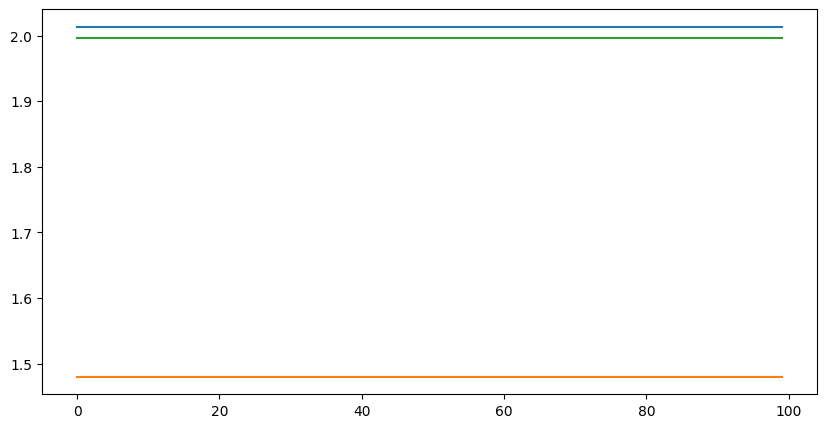

In [3]:
from matplotlib import pyplot as plt

# generate synthetic data
x = torch.randn(10).to('cuda')
target = torch.randn(1).to('cuda')


num_estimates = [1, 5, 10, 20, 50, 100]

plt.figure(figsize=(10, 5))

for q in num_estimates:
    net = Net().to('cuda')
    optimizer = ZOOptimizer(optim.SGD, net.parameters(), compute_loss, q=q, mu=1e-5, sides=1)
    losses = []
    for i in range(100):
        optimizer.step(net, x, target)
        with torch.no_grad():
            loss = compute_loss(net, x, target)
            losses.append(loss.item())
    plt.plot(losses, label=f'q={q}')

    del net
    del optimizer

plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
# compare multiple perturabation radii
# radii = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

# plt.figure(figsize=(10, 5))

# for mu in radii:
#     net = Net().to('cuda')
#     optimizer = ZOOptimizer(optim.Adam, net.parameters(), compute_loss, q=100, mu=mu, sides=1)
#     losses = []
#     for i in range(100):
#         optimizer.step(net, x, target)
#         with torch.no_grad():
#             loss = compute_loss(net, x, target)
#             losses.append(loss.item())
#     plt.plot(losses, label=f'mu={mu}')
    
#     del net
#     del optimizer


# plt.yscale('log')
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Loss')

KeyboardInterrupt: 

<Figure size 1000x500 with 0 Axes>

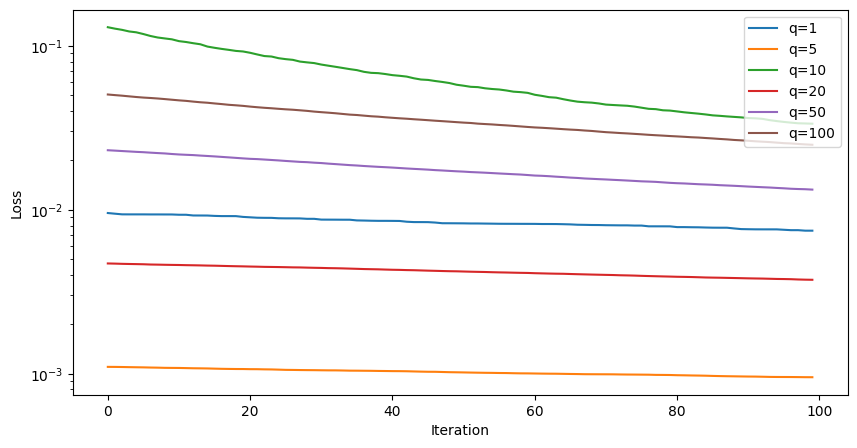

In [ ]:
# generate synthetic data
x = torch.randn(10).to('cuda')
target = torch.randn(1).to('cuda')


num_estimates = [1, 5, 10, 20, 50, 100]
# num_estimates = [10]

plt.figure(figsize=(10, 5))

for q in num_estimates:
    net = Net().to('cuda')
    optimizer = ZOOptimizer(optim.SGD, net.parameters(), compute_loss_2, q=q, mu=1e-5, sides=1)
    losses = []
    for i in range(100):
        optimizer.pseudo(net, x, target)
        with torch.no_grad():
            loss = compute_loss(net, x, target)
            losses.append(loss.item())
    plt.plot(losses, label=f'q={q}')

    del net
    del optimizer

plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()